In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import forced_phot as fp

In [23]:
sjoertpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares' 
ztf_name = 'ZTF19accdntg'
ztf_dir = os.path.join(sjoertpath,ztf_name)
time_zeropoint = 2458484.5 #JD of 01-01-2019 @ 00:00:00.000


In [24]:
clean_data = pd.read_csv(os.path.join(ztf_dir,f"{ztf_name}_clean_data.txt"),
                            sep='\t',comment='#',
                            names=['time','flux','flux_unc','zeropoint','filter'])
clean_data.sort_values('time',inplace=True) #sort the data by time for plotting reasons later on
no_i_mask = clean_data['filter'] != 'ZTF_i' #create the ZTf_i mask to filter out ZTF-i-band data.
flux,err = fp.flux_jy(clean_data) #convert the flux and its errors to uJY
err = np.clip(err,0.01*flux,np.inf) # clip the errors to be at least 1% of the flux
clean_data['flux'] = flux.values #overwrite with new data
clean_data['flux_unc'] = err.values 

#create numpy arrays for ease and efficiency
flux, err, time = clean_data[['flux','flux_unc','time']].T.to_numpy(dtype=np.float64)

time_zeropoint = 2458484.5 #JD of 01-01-2019 @ 00:00:00.000
#transform time column
time_mjd = clean_data['time'] - time_zeropoint
clean_data['time'] = time_mjd.values 


In [25]:
def cross_correlation(flux,time,time_zeropoint=2458484.5,full_output=True):
    latest_peak =  2459945.49999  #jd of 31-12-2022 23:59:59.000
    latest_peak -= time_zeropoint #in mjd

    #it may be the case we don't have data beyond the latest peak, 
    #in which case we take the latest datapoint as the latest peak
    if latest_peak > np.max(time):
        latest_peak = np.max(time)

    timesteps_for_gauss = np.arange(np.min(time[1:]),latest_peak,step=5) #key array that deduces the times which will become candidates
    cross_corr = np.zeros_like(timesteps_for_gauss)

    #interpolate the data at the timesteps we use so that the arrays have the same shape.
    interp_data = np.interp(timesteps_for_gauss,time,flux)

    for i,t in enumerate(timesteps_for_gauss):
        #we evaluate the gaussian at the defined timesteps and use the interpolated data to compare to. This usually reduces 
        #runtime greatly compared to evaluating the gaussian at all times in "time" and using the actual flux data
        #and gives comparable results.
        cross_corr[i] = np.dot(fp.gaussian(timesteps_for_gauss,amp=1,mu=t),interp_data)
    
    #best fit is the highest cross correlation
    peak = np.argmax(cross_corr)

    #finding the flux of the closest corresponding time in the actual data as the corresponding flux to the peak guess
    best_time_insteps = timesteps_for_gauss[peak]
    best_fit_arg = np.argmin(np.abs(time - best_time_insteps))
    best_flux = flux[best_fit_arg]

    if full_output:
        return cross_corr, peak, timesteps_for_gauss, best_flux
    return peak,timesteps_for_gauss[peak],best_flux

cross_cor_landscape, peak, timesteps, best_flux = cross_correlation(flux[clean_data['filter'] == 'ZTF_r'],time_mjd[clean_data['filter'] == 'ZTF_r'])

<ErrorbarContainer object of 3 artists>

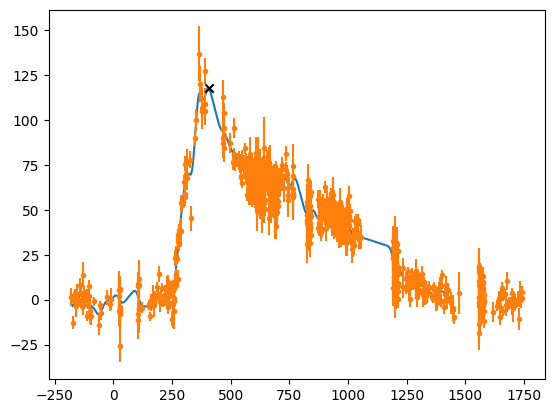

In [26]:
plt.plot(timesteps,cross_cor_landscape)
plt.scatter(timesteps[peak],cross_cor_landscape[peak],marker='x',zorder=10,c='black')
# plt.show()

plt.errorbar(time_mjd[clean_data['filter'] == 'ZTF_r'],flux[clean_data['filter'] == 'ZTF_r'],err[clean_data['filter'] == 'ZTF_r'],fmt='.')

<ErrorbarContainer object of 3 artists>

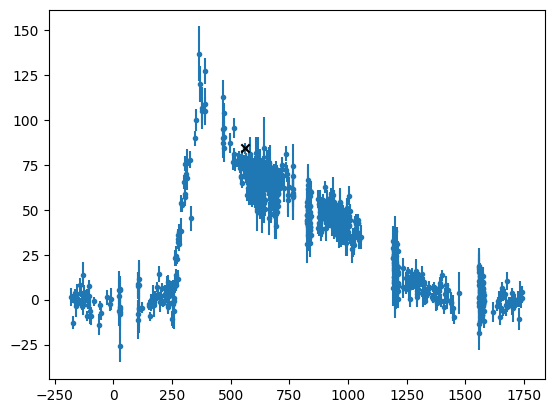

In [27]:
chi2_landscape, peak_chi, timesteps_chi, best_flux_chi = fp.chi2_peak_finder(flux,err,time_mjd.values,time_zeropoint)
# plt.plot(timesteps_chi,chi2_landscape)
plt.scatter(timesteps_chi,best_flux_chi,marker='x',zorder=10,c='black')
# plt.show()

plt.errorbar(time_mjd[clean_data['filter'] == 'ZTF_r'],flux[clean_data['filter'] == 'ZTF_r'],err[clean_data['filter'] == 'ZTF_r'],fmt='.')

In [29]:
%timeit cross_correlation(flux,time_mjd)

8.42 ms ± 975 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
%timeit fp.chi2_peak_finder(flux,err,time_mjd.values,time_zeropoint)

25.4 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
